<a href="https://colab.research.google.com/github/Ayush-Dutta/Vision-Transformer/blob/main/Internship_project_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install keras
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
num_classes=10
input_shape = (32,32,3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print (f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print (f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [4]:
#input_shape = (32,32,3)

In [5]:
x_train=x_train[:500]
y_train=y_train[:500]
x_test=x_test[:500]
y_ttest=y_test[:500]

In [6]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72
patch_size= 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads=4
transformer_units = [
    projection_dim*2,
    projection_dim
]
transformer_layers=8
mlp_head_units = [2048, 1024]

In [7]:
data_augmentation = keras.Sequential(
    [
      layers.Normalization(),
      layers.Resizing(image_size, image_size),
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(factor=0.02),
      layers.RandomZoom(
          height_factor = 0.2, width_factor = 0.2)
    ],
    name="data_augmentation"
)
data_augmentation.layers[0].adapt(x_train)

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [9]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super(Patches, self). __init__()
    self.patch_size = patch_size

  def call (self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1,self.patch_size, self.patch_size, 1],
        rates=[1,1,1,1],
        padding="VALID",
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches,[batch_size,-1,patch_dims])
    return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


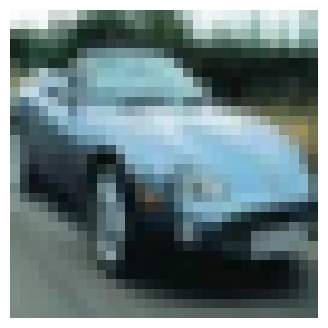

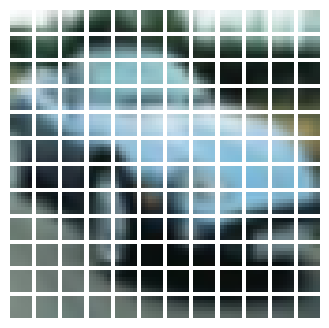

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size= (image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print (f"Image size: {image_size} X {image_size}")
print (f"Patch size: {patch_size} X {patch_size}")
print (f"Patches per image: {patches.shape[1]}")
print (f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i+1)
  patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.axis("off")


In [11]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [12]:
def create_vit_classifier(input_shape):
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
      x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
      attention_output = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=projection_dim, dropout=0.1
          )(x1,x1)
      x2 = layers.Add()([attention_output, encoded_patches])
      x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
      x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
      encoded_patches = layers.Add()([x3,x2])
      representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
      representation = layers.Flatten()(representation)
      representation = layers.Dropout(0.5)(representation)
      features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
      logits = layers.Dense(num_classes)(features)
      model = keras.Model(inputs=inputs, outputs=logits)
      return model

In [13]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay  # Corrected typo
    )
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[  # Corrected typo
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top_5_accuracy"),  # Corrected typo
        ],
    )
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    history = model.fit(
        x=x_train,  # Corrected argument name
        y=y_train,  # Corrected argument name
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

In [14]:
vit_classifier = create_vit_classifier(input_shape)
history = run_experiment(vit_classifier)

Epoch 1/40
2/2 [==============================] - 18s 5s/step - loss: 5.3187 - accuracy: 0.1333 - top_5_accuracy: 0.5511 - val_loss: 5.6406 - val_accuracy: 0.1400 - val_top_5_accuracy: 0.6800
Epoch 2/40
2/2 [==============================] - 7s 3s/step - loss: 5.4477 - accuracy: 0.2578 - top_5_accuracy: 0.6911 - val_loss: 3.4552 - val_accuracy: 0.2400 - val_top_5_accuracy: 0.7000
Epoch 3/40
2/2 [==============================] - 8s 4s/step - loss: 4.1329 - accuracy: 0.2556 - top_5_accuracy: 0.7244 - val_loss: 2.8625 - val_accuracy: 0.2600 - val_top_5_accuracy: 0.7200
Epoch 4/40
2/2 [==============================] - 6s 3s/step - loss: 3.5108 - accuracy: 0.2778 - top_5_accuracy: 0.7556 - val_loss: 2.9426 - val_accuracy: 0.1600 - val_top_5_accuracy: 0.7200
Epoch 5/40
2/2 [==============================] - 7s 3s/step - loss: 2.7956 - accuracy: 0.3578 - top_5_accuracy: 0.8044 - val_loss: 2.1011 - val_accuracy: 0.3200 - val_top_5_accuracy: 0.7800
Epoch 6/40
2/2 [============================

ValueError: Data cardinality is ambiguous:
  x sizes: 500
  y sizes: 10000
Make sure all arrays contain the same number of samples.